### Review results of fine tuning Alexnet on food-101 data.

__Data Pre-Processing:__

All images were first rescaled to 256 x 256, and each class of 1,000 images was split into:

- Training - 664 images
- Validation - 136 images
- Testing - 200 images

__Data Augmentation:__

Data augmentation was enabled during testing to allow random crops and mirroring of images

__Solver.prototxt:__

- test_iter: 1000
- test_interval: 1000
- base_lr: 0.001
- lr_policy: "step"
- gamma: 0.1
- stepsize: 2500
- display: 50
- max_iter: 30000
- momentum: 0.9
- weight_decay: 0.0005
- snapshot: 5000


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import caffe
import os
import numpy as np
import sys

sys.path.append("/usr/local/caffe/tools/extra")
import parse_log as pl

sys.path.append('../')
import helpers.histogram_classifier as hc

In [4]:
from IPython.core.display import HTML
css = open('styles/table-style.css').read() #+ open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [5]:
train_log, test_log = pl.parse_log("../transfer-learning/data/alexnet_3/train.log")

In [6]:
train_iters = [x['NumIters'] for x in train_log]
train_loss = [x['loss'] for x in train_log]
test_iters = [x['NumIters'] for x in test_log]
test_loss = [x['loss'] for x in test_log]
test_accuracy = [x['accuracy'] for x in test_log]

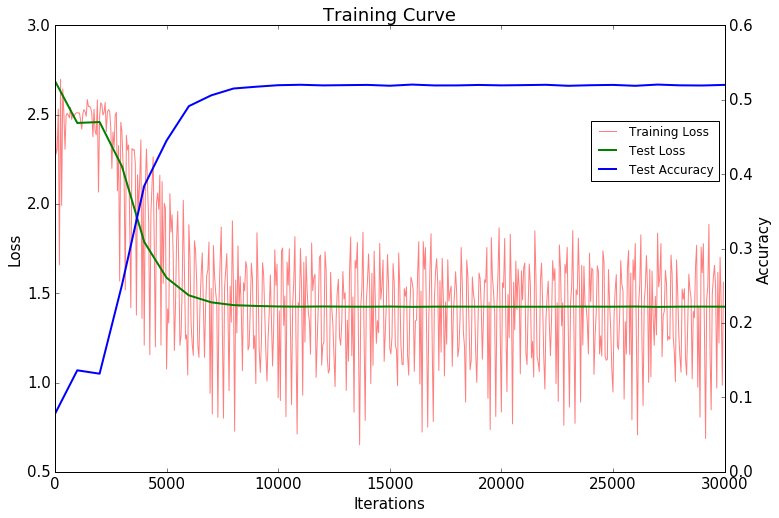

In [8]:
fig, ax1 = plt.subplots(figsize=(12,8))

#Plotting training and test losses
train_l ,= ax1.plot(train_iters, train_loss, color='red',  alpha=.5, label='Training loss')
test_l ,= ax1.plot(test_iters, test_loss, linewidth=2, color='green', label='Test loss')
#ax1.set_ylim(ymin=0, ymax=1)
ax1.set_xlabel('Iterations', fontsize=15)
ax1.set_ylabel('Loss', fontsize=15)
ax1.tick_params(labelsize=15)
#Plotting test accuracy
ax2 = ax1.twinx()
test_acc ,= ax2.plot(test_iters, test_accuracy, linewidth=2, color='blue', label='Test accuracy')
#ax2.set_ylim(ymin=0, ymax=1)
ax2.set_ylabel('Accuracy', fontsize=15)
ax2.tick_params(labelsize=15)
#Adding legend
plt.legend([train_l, test_l, test_acc], ['Training Loss', 'Test Loss', 'Test Accuracy'],  bbox_to_anchor=(1, 0.8))
plt.title('Training Curve', fontsize=18)
plt.show()

### Results from predictions on test data

In [9]:
predictions = np.load("../transfer-learning/data/alexnet_3/predictions", encoding='latin1')

In [10]:
prediction_mapping = eval(open('../transfer-learning/data/alexnet_3/class_mapping.txt', 'r').read())
reverse_prediction_mapping = { v:k for k,v in prediction_mapping.items() }
classes = [reverse_prediction_mapping[x] for x in range(12)]

In [11]:
with open("../transfer-learning/data/alexnet_3/test.txt", "rb") as f:
    test_images = f.read().splitlines()

In [12]:
# Get true and predicted classes
true = []
predicted = []

for x, y in zip(test_images, predictions):
    true.append(reverse_prediction_mapping[int(x.decode().split(" ")[1])])
    predicted.append(reverse_prediction_mapping[np.argmax(y)])

In [13]:
score, metrics, confusion = hc.get_metrics(true, predicted, classes)

In [14]:
score

,Accuracy,F1,Precision,Recall
Results,0.501,0.501,0.51,0.501


In [15]:
metrics

,Precision,Recall,F1-Score,Support
pork_chop,0.41,0.52,0.46,200.0
lasagna,0.42,0.56,0.48,200.0
french_toast,0.40,0.39,0.39,200.0
guacamole,0.79,0.74,0.77,200.0
apple_pie,0.40,0.40,0.40,200.0
cheesecake,0.48,0.50,0.49,200.0
hamburger,0.46,0.48,0.47,200.0
fried_rice,0.70,0.68,0.69,200.0
carrot_cake,0.39,0.44,0.41,200.0
chocolate_cake,0.61,0.50,0.55,200.0


In [16]:
confusion

,pork_chop,lasagna,french_toast,guacamole,apple_pie,cheesecake,hamburger,fried_rice,carrot_cake,chocolate_cake,steak,pizza
pork_chop,104,26,12,2,9,2,10,10,8,2,13,2
lasagna,10,112,2,1,15,9,10,10,7,1,2,21
french_toast,11,17,78,3,26,12,16,0,20,5,5,7
guacamole,2,3,1,149,0,4,21,8,2,3,2,5
apple_pie,5,15,28,2,80,7,13,4,36,2,1,7
cheesecake,4,6,5,0,15,101,15,0,21,25,5,3
hamburger,20,7,15,7,18,10,97,1,10,1,4,10
fried_rice,6,19,2,11,8,3,2,137,3,4,0,5
carrot_cake,10,7,20,2,21,18,10,4,89,10,7,2
chocolate_cake,10,1,11,2,0,34,2,1,15,100,23,1


### Per class Precision-Recall curves

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [18]:
y_probs = predictions
y_test = np.array(true)

In [19]:
precision = dict()
recall = dict()
average_precision = dict()
for i, c in enumerate(classes):
    t = (y_test == c).astype(int)
    s = y_probs[:, i]
    precision[c], recall[c], _ = precision_recall_curve(t, s)
    average_precision[c] = average_precision_score(t, s)

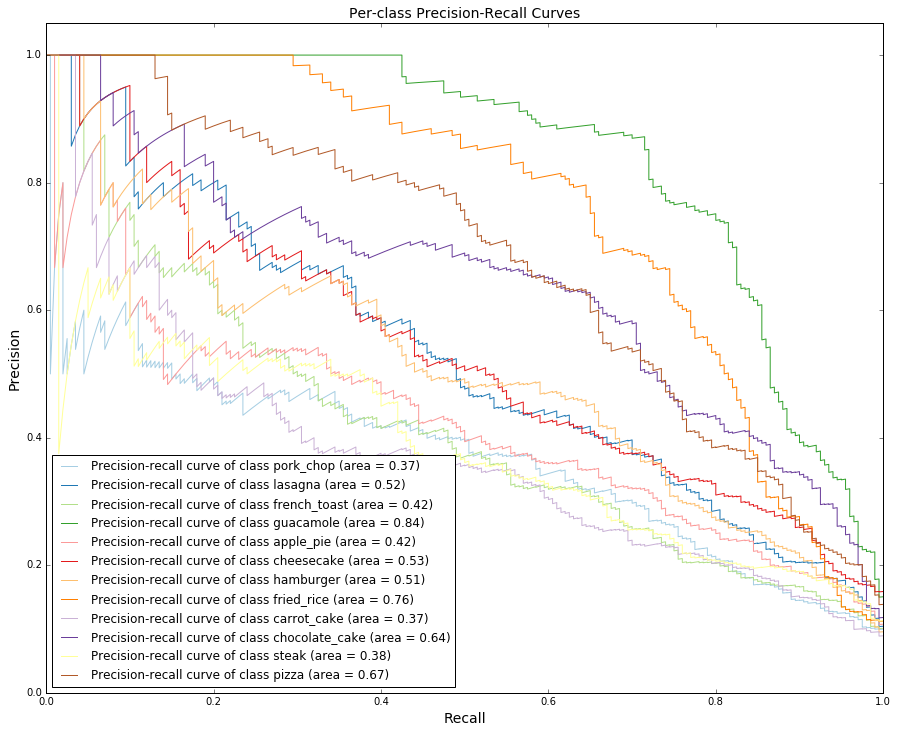

In [20]:
# Plot Precision-Recall curve for each class
colors = ('#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928')
fig, ax = plt.subplots(figsize=(15,12))
ax.set_axis_bgcolor('white')
for cl, co in zip(classes, colors):
    plt.plot(recall[cl], precision[cl], color=co,
             label='Precision-recall curve of class {} (area = {:.2f})'.format(cl, average_precision[cl]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', size=14)
plt.ylabel('Precision', size=14)
plt.title('Per-class Precision-Recall Curves', size=14)
plt.legend(loc="lower left", prop={'size':12})
plt.show()

### Accuracy for top 2 classes

In [21]:
hc.top_n_class_accuracy(y_probs, classes, np.array(true), 2)

0.70125